# Study Areas Definition and Grid Generation

This notebook defines the study areas for UHI analysis and generates standardised 30m×30m grid cells for spatial analysis. Each city gets an 82×82 grid (6,724 cells) covering approximately 6.05 km² with aligned bounds in EPSG:3857 projection for accurate distance calculations.

## Overview

- **Selected Cities**: Amsterdam, Athens, Barcelona, Berlin, Madrid, Paris
- **Grid Resolution**: 30m × 30m cells
- **Grid Size**: 82 × 82 cells per city (6,724 total)
- **Coverage**: ~6.05 km² per city
- **Projection**: EPSG:3857 (Web Mercator) for accurate spatial operations

## 1. Setup and Configuration

In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import box
import warnings

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.bbox_utils import get_all_study_cities_bbox

# Configuration
CITIES = ['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Madrid', 'Paris']
GRID_SIZES = [30, 60, 90]  # metres
DATA_DIR = PROJECT_ROOT / 'data'
EXPORT_DIR = DATA_DIR / 'utils'
EXPORT_ROOT = EXPORT_DIR / 'grids'

# Create export directories
(EXPORT_DIR / 'bbox').mkdir(parents=True, exist_ok=True)
EXPORT_ROOT.mkdir(parents=True, exist_ok=True)

FIG_DIR = PROJECT_ROOT / 'results' / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 2. Study Cities Selection
- We selected these six European cities (Amsterdam, Athens, Barcelona, Berlin, Madrid, and Paris) to capture a range of climate zones and urban forms within Europe, while ensuring sufficient data coverage in the GlobalStreetscapes dataset. 

- The cities represent both Marine West Coast (Cfb) and Mediterranean (Csa) climate types, allowing for comparative analysis across different environmental and urban contexts. 

- Each city also has a substantial number of available street-level images, which is essential for robust spatial analysis.

In [8]:
def load_study_cities():
    """Load and filter Global Streetscapes cities dataset for our study cities"""
    cities_df = pd.read_csv('https://huggingface.co/datasets/NUS-UAL/global-streetscapes/resolve/main/cities688.csv')
    selected_columns = ['city', 'img_count', 'continent', 'koppen_geiger_zone', 'zone_description', 'city_lat', 'city_lon', 'country']
    study_area_table = cities_df[(cities_df['city'].isin(CITIES)) & ((cities_df['city'] != 'Madrid') | (cities_df['country'] == 'Spain'))][selected_columns].sort_values('city')
    return study_area_table

study_area_table = load_study_cities()
print(f"Climate zones: {study_area_table['koppen_geiger_zone'].unique()}")
print(f"Total street images: {study_area_table['img_count'].sum():,}")
study_area_table


Climate zones: ['Cfb' 'Csa']
Total street images: 464,912


city  img_count continent koppen_geiger_zone  \
221  Amsterdam      26421    Europe                Cfb   
396     Athens     106003    Europe                Csa   
508  Barcelona      21218    Europe                Csa   
456     Berlin     281033    Europe                Cfb   
339     Madrid      16124    Europe                Csa   
176      Paris      14113    Europe                Cfb   

                   zone_description  city_lat  city_lon      country  
221  Marine west coast, warm summer   52.3667    4.8833  Netherlands  
396       Mediterranean, hot summer   37.9842   23.7281       Greece  
508       Mediterranean, hot summer   41.3825    2.1769        Spain  
456  Marine west coast, warm summer   52.5167   13.3833      Germany  
339       Mediterranean, hot summer   40.4167   -3.7167        Spain  
176  Marine west coast, warm summer   48.8566    2.3522       France

## 3. Bounding Box Generation
Using the tiles zoom level 14 and the area of Global Streetscapes Study Areas

In [9]:

def generate_bounding_boxes():
    """Generate aligned bounding boxes for all study cities"""
    bboxes_gdf = get_all_study_cities_bbox(align_to_grid=True)
    bboxes_gdf = bboxes_gdf.sort_values('city')
    bboxes_3857 = bboxes_gdf.to_crs('EPSG:3857')
    bboxes_3857['area_m2'] = bboxes_3857.geometry.area
    bboxes_3857['area_km2'] = bboxes_3857['area_m2'] / 1_000_000
    return bboxes_gdf, bboxes_3857

bboxes_gdf, bboxes_3857 = generate_bounding_boxes()
print(f"Grid alignment: {'Yes' if bboxes_gdf['grid_aligned'].all() else 'No'}")
print(f"Standardised area: {bboxes_3857['area_km2'].iloc[0]:.3f} km² per city")
print(f"Cells per city: {bboxes_gdf['total_cells'].iloc[0]:,}")


Grid alignment: Yes
Standardised area: 6.052 km² per city
Cells per city: 6,724


In [10]:
bbox_export_path = EXPORT_DIR / 'bbox' / 'all_study_cities_bbox.parquet'
bboxes_gdf.to_parquet(bbox_export_path, index=False)
print(f'Saved bbox parquet to {bbox_export_path}')

Saved bbox parquet to /Users/gerardoezequiel/Developer/ShapingCoolCities/data/utils/bbox/all_study_cities_bbox.parquet


## 4. Generate aligned grids and export

In [11]:

def generate_city_grids(bboxes_gdf: gpd.GeoDataFrame, grid_size: int):
    """Generate grid cells for each city using aligned bounds."""
    grids_by_city = {}
    all_grids = []
    for _, row in bboxes_gdf.iterrows():
        city = row['city']
        minx_base, miny_base = row['minx_3857'], row['miny_3857']
        maxx_base, maxy_base = row['maxx_3857'], row['maxy_3857']
        minx = np.floor(minx_base / grid_size) * grid_size
        miny = np.floor(miny_base / grid_size) * grid_size
        span_x = maxx_base - minx_base
        span_y = maxy_base - miny_base
        steps_x = int(np.ceil(span_x / grid_size))
        steps_y = int(np.ceil(span_y / grid_size))
        maxx = minx + steps_x * grid_size
        maxy = miny + steps_y * grid_size
        grid_cells = []
        for x in np.arange(minx, maxx, grid_size):
            for y in np.arange(miny, maxy, grid_size):
                cell = box(x, y, x + grid_size, y + grid_size)
                grid_cells.append(cell)
        grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:3857')
        grid_gdf = grid_gdf.reset_index(drop=True)
        grid_gdf['city'] = city
        grid_gdf['global_grid_id'] = city + '_' + grid_gdf.index.astype(str)
        grid_gdf['grid_size_m'] = grid_size
        _ = grid_gdf.sindex
        grids_by_city[city] = grid_gdf
        all_grids.append(grid_gdf)
    combined_grid = gpd.GeoDataFrame(pd.concat(all_grids, ignore_index=True), crs='EPSG:3857')
    combined_grid['grid_size_m'] = grid_size
    return grids_by_city, combined_grid


### Multi-resolution grid exports
We generate 30, 60, and 90 m grids for each city so the MAUP sensitivity notebook can reuse the same canonical IDs. The 30 m grid is the primary modelling surface; 60/90 m outputs exist solely for the MAUP experiments.

=== Generating 30 m grids ===
  Total cells: 40,344 (6,724 per city)
  Saved combined grid to /Users/gerardoezequiel/Developer/ShapingCoolCities/data/utils/grids/all_cities_30m_grid.parquet


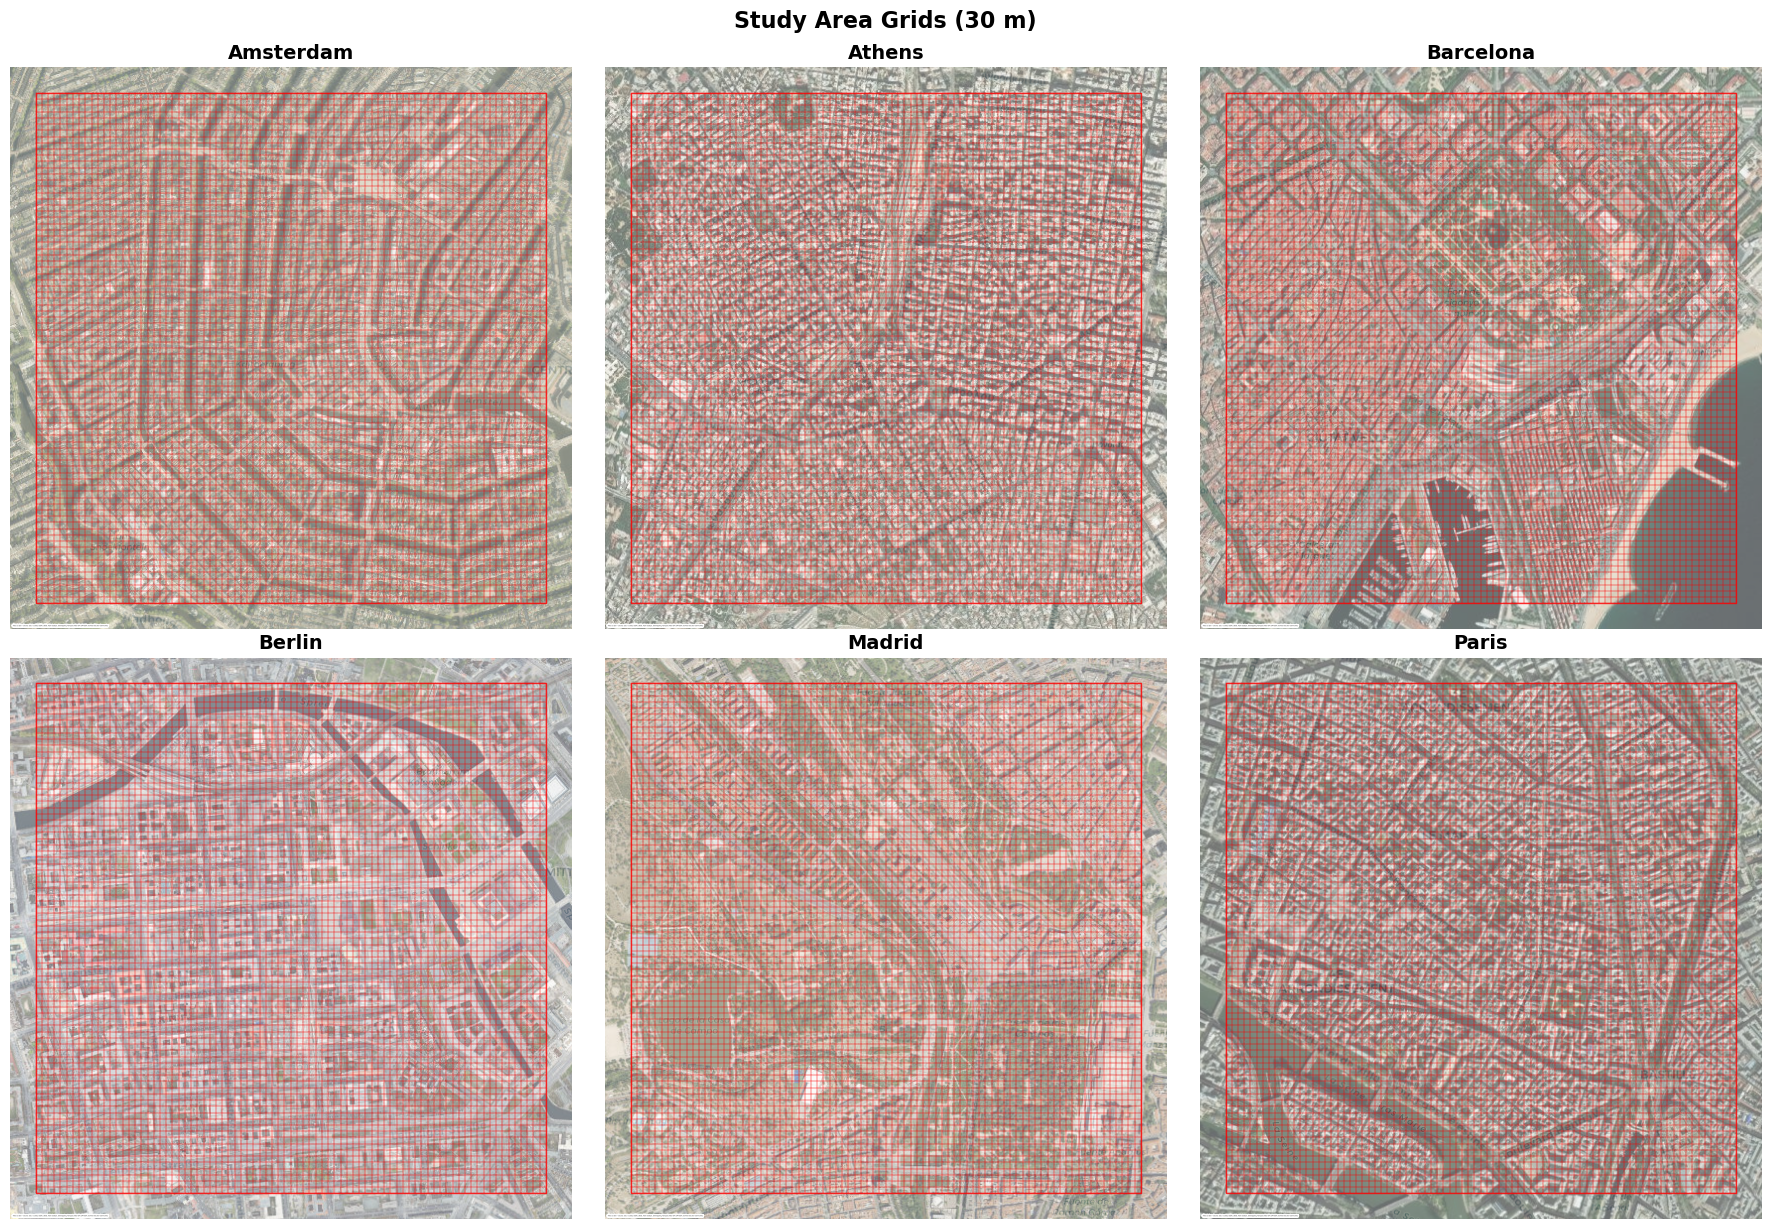

=== Generating 60 m grids ===
  Total cells: 10,086 (1,681 per city)
  Saved combined grid to /Users/gerardoezequiel/Developer/ShapingCoolCities/data/utils/grids/all_cities_60m_grid.parquet
=== Generating 90 m grids ===
  Total cells: 4,704 (784 per city)
  Saved combined grid to /Users/gerardoezequiel/Developer/ShapingCoolCities/data/utils/grids/all_cities_90m_grid.parquet


In [12]:
# Generate, export, and (for 30 m) visualise grids across resolutions
plot_bboxes_3857 = bboxes_gdf.to_crs('EPSG:3857')
resolution_outputs = {}

for grid_size in GRID_SIZES:
    print(f"=== Generating {grid_size} m grids ===")
    grids_by_city, combined_grid = generate_city_grids(bboxes_gdf, grid_size)
    resolution_outputs[grid_size] = (grids_by_city, combined_grid)

    total_cells = len(combined_grid)
    cells_per_city = total_cells // len(CITIES)
    print(f"  Total cells: {total_cells:,} ({cells_per_city:,} per city)")

    combined_path = EXPORT_ROOT / f'all_cities_{grid_size}m_grid.parquet'
    combined_grid.to_parquet(combined_path, index=False)
    print(f"  Saved combined grid to {combined_path}")

    if grid_size == GRID_SIZES[0]:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        for ax, (city, grid_gdf) in zip(axes, grids_by_city.items()):
            grid_gdf.boundary.plot(ax=ax, linewidth=0.3, color='red', alpha=0.6)
            plot_bboxes_3857[plot_bboxes_3857['city'] == city].boundary.plot(ax=ax, color='red', alpha=0.8, linewidth=1)
            ctx.add_basemap(
                ax,
                source=ctx.providers.CartoDB.Positron,
                crs=grid_gdf.crs,
                attribution_size=1
            )
            ctx.add_basemap(
                ax,
                source=ctx.providers.Esri.WorldImagery,
                crs=grid_gdf.crs,
                alpha=0.5,
                attribution_size=1
            )
            ax.set_title(city, fontsize=14, fontweight='bold')
            ax.set_axis_off()
        plt.tight_layout()
        plt.suptitle(f'Study Area Grids ({grid_size} m)', fontsize=16, fontweight='bold', y=1.02)
        fig_path = FIG_DIR / f'study_grids_{grid_size}m.png'
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        plt.show()
